# Análisis de Estado del Negocio

#### Sección 1: Setup y Definición de Modelos

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple

# Configuración básica para gráficos
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10


# Definición de Clases del Modelo

class ProductoCredito:
    """
    Clase que representa un producto de crédito con sus características financieras
    """
    
    def __init__(self, nombre: str, monto_prestamo: float, tasa_interes: float, 
                 tasa_dq: float, clientes_iniciales: int, tasa_crecimiento_mensual: float):
        self.nombre = nombre
        self.monto_prestamo = monto_prestamo
        self.tasa_interes = tasa_interes
        self.tasa_dq = tasa_dq
        self.clientes_iniciales = clientes_iniciales
        self.tasa_crecimiento_mensual = tasa_crecimiento_mensual
        
    def calcular_clientes_mes(self, mes: int) -> int:
        """Calcula el número de clientes en un mes dado (mes 0 = inicial)"""
        return int(self.clientes_iniciales * (1 + self.tasa_crecimiento_mensual) ** mes)
    
    def calcular_revenue_mes(self, clientes: int) -> float:
        """Calcula el revenue del mes basado en clientes que pagan"""
        clientes_que_pagan = clientes * (1 - self.tasa_dq)
        return clientes_que_pagan * self.monto_prestamo * self.tasa_interes
    
    def calcular_losses_mes(self, clientes: int) -> float:
        """Calcula las pérdidas del mes por clientes en DQ - SOLO CAPITAL"""
        clientes_dq = clientes * self.tasa_dq
        return clientes_dq * self.monto_prestamo  # Solo capital, no interés
    
    def __str__(self):
        return f"{self.nombre}: ${self.monto_prestamo:,} @ {self.tasa_interes:.1%} interés, {self.tasa_dq:.1%} DQ"


class StartupFintech:
    """
    Clase principal que modela la operación completa de la startup
    """
    
    def __init__(self, productos: List[ProductoCredito], costo_operativo_por_cuenta: float):
        self.productos = productos
        self.costo_operativo_por_cuenta = costo_operativo_por_cuenta
        self.proyeccion = None
        
    def calcular_proyeccion_mensual(self, periodo_meses: int) -> pd.DataFrame:
        """
        Genera la proyección financiera mes a mes
        """
        resultados = []
        
        for mes in range(periodo_meses):
            mes_data = {'mes': mes + 1}
            
            # Métricas por producto
            total_clientes = 0
            total_revenue = 0
            total_losses = 0
            
            for producto in self.productos:
                clientes_mes = producto.calcular_clientes_mes(mes)
                revenue_mes = producto.calcular_revenue_mes(clientes_mes)
                losses_mes = producto.calcular_losses_mes(clientes_mes)
                
                # Guardar métricas del producto
                mes_data[f'clientes_{producto.nombre}'] = clientes_mes
                mes_data[f'revenue_{producto.nombre}'] = revenue_mes
                mes_data[f'losses_{producto.nombre}'] = losses_mes
                
                # Sumar a totales
                total_clientes += clientes_mes
                total_revenue += revenue_mes
                total_losses += losses_mes
            
            # Cálculos totales del mes
            costos_operativos = total_clientes * self.costo_operativo_por_cuenta
            net_income = total_revenue - total_losses - costos_operativos
            
            mes_data.update({
                'total_clientes': total_clientes,
                'total_revenue': total_revenue,
                'total_losses': total_losses,
                'costos_operativos': costos_operativos,
                'net_income': net_income
            })
            
            resultados.append(mes_data)
        
        self.proyeccion = pd.DataFrame(resultados)
        return self.proyeccion
    
    def mostrar_resumen_productos(self):
        """Muestra un resumen de los productos configurados"""
        print("=== PRODUCTOS CONFIGURADOS ===")
        for producto in self.productos:
            print(producto)
        print(f"\nCosto operativo por cuenta: ${self.costo_operativo_por_cuenta}")


# Configuración de Parámetros del Caso
producto_a = ProductoCredito(
    nombre="A",
    monto_prestamo=1000,
    tasa_interes=0.15,
    tasa_dq=0.135,
    clientes_iniciales=5000,
    tasa_crecimiento_mensual=0.25
)

producto_b = ProductoCredito(
    nombre="B", 
    monto_prestamo=2000,
    tasa_interes=0.10,
    tasa_dq=0.08,
    clientes_iniciales=10000,
    tasa_crecimiento_mensual=0.10
)

# Inicialización de la startup
startup = StartupFintech(
    productos=[producto_a, producto_b],
    costo_operativo_por_cuenta=30
)

# Mostrar configuración
startup.mostrar_resumen_productos()

=== PRODUCTOS CONFIGURADOS ===
A: $1,000 @ 15.0% interés, 13.5% DQ
B: $2,000 @ 10.0% interés, 8.0% DQ

Costo operativo por cuenta: $30


#### Seccion 2: Construccion del Modelo mes a mes

In [4]:
# Ejecutar proyección de 12 meses
proyeccion_12m = startup.calcular_proyeccion_mensual(12)

# Ver los primeros resultados
print("Primeros 3 meses de proyección:")
print(proyeccion_12m.head(12))

Primeros 3 meses de proyección:
    mes  clientes_A   revenue_A   losses_A  clientes_B  revenue_B   losses_B  \
0     1        5000   648750.00   675000.0       10000  1840000.0  1600000.0   
1     2        6250   810937.50   843750.0       11000  2024000.0  1760000.0   
2     3        7812  1013607.00  1054620.0       12100  2226400.0  1936000.0   
3     4        9765  1267008.75  1318275.0       13310  2449040.0  2129600.0   
4     5       12207  1583858.25  1647945.0       14641  2693944.0  2342560.0   
5     6       15258  1979725.50  2059830.0       16105  2963320.0  2576800.0   
6     7       19073  2474721.75  2574855.0       17715  3259560.0  2834400.0   
7     8       23841  3093369.75  3218535.0       19487  3585608.0  3117920.0   
8     9       29802  3866809.50  4023270.0       21435  3944040.0  3429600.0   
9    10       37252  4833447.00  5029020.0       23579  4338536.0  3772640.0   
10   11       46566  6041938.50  6286410.0       25937  4772408.0  4149920.0   
11   12 

#### Sección 3: Visualización de Tendencias

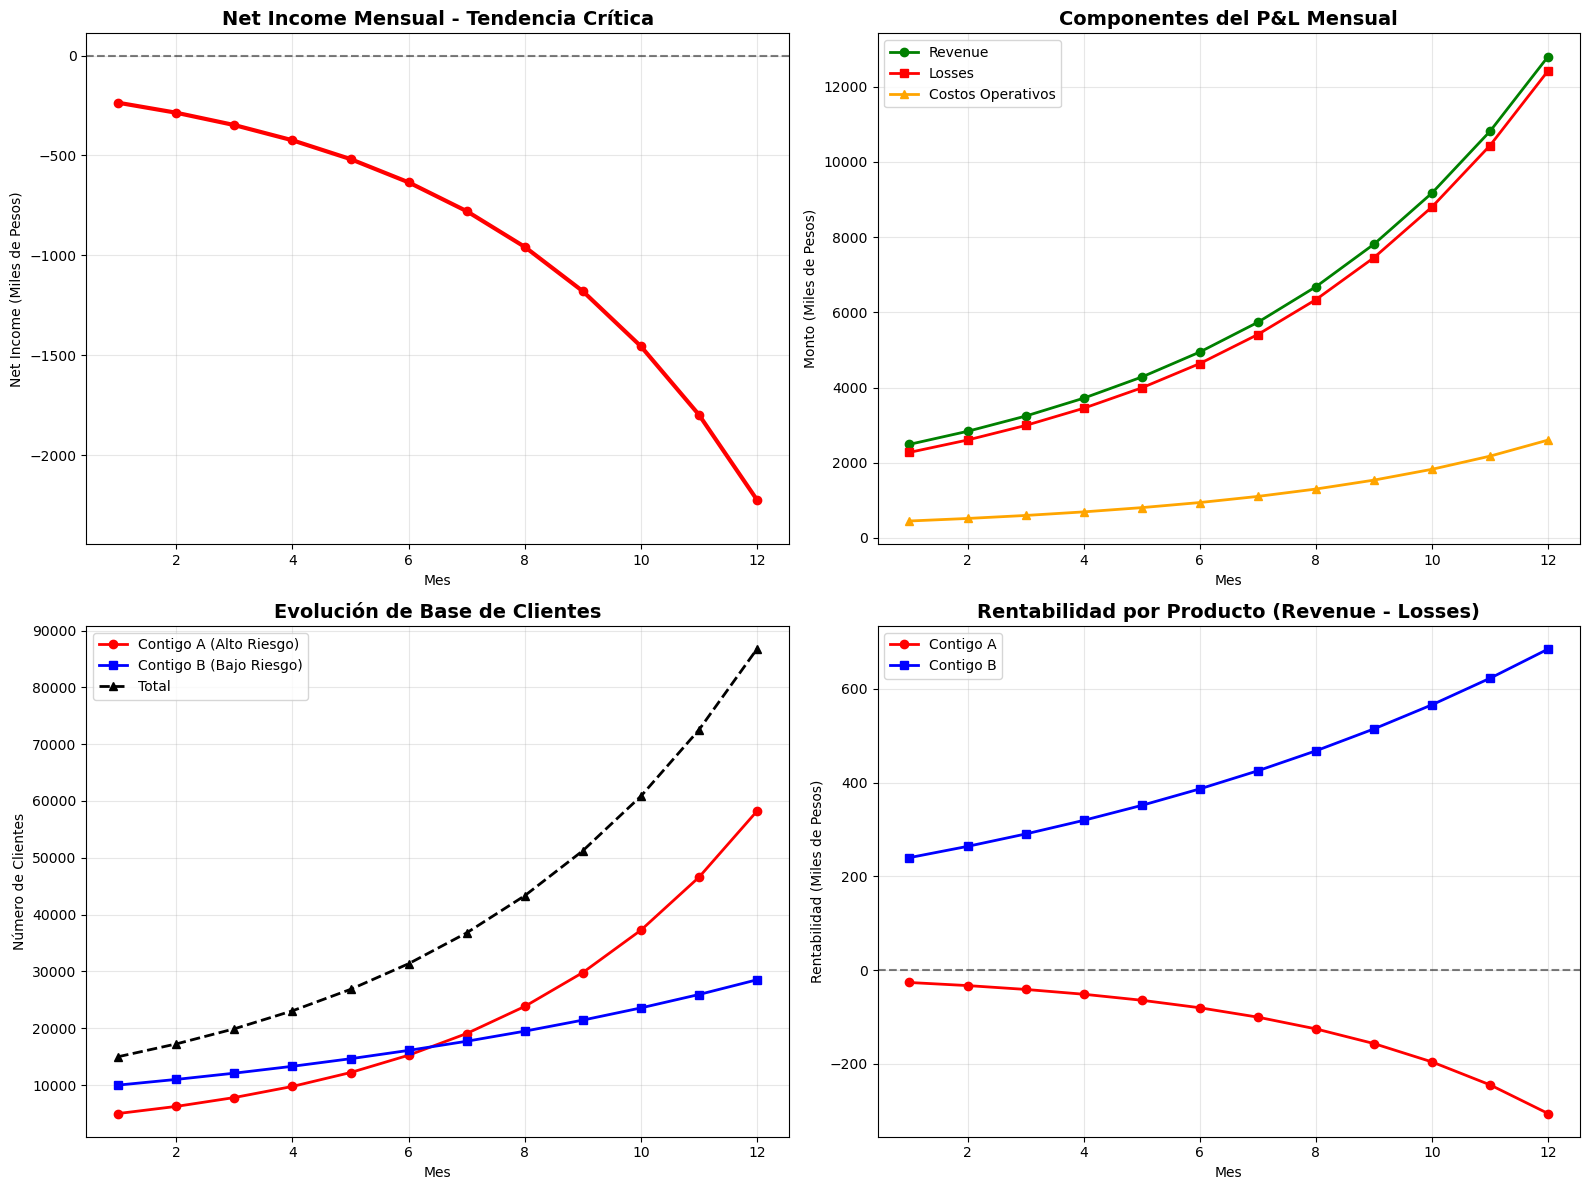

=== ANÁLISIS DE TENDENCIAS CRÍTICAS ===

1. NET INCOME EVOLUTION:
   Mes 1: $-236,250
   Mes 12: $-2,222,983
   Deterioro: $-1,986,733

2. CRECIMIENTO DE REVENUE vs LOSSES:
   Revenue Mes 1→12: $2,488,750 → $12,802,062
   Losses Mes 1→12: $2,275,000 → $12,422,905
   Ratio Revenue crecimiento: 5.1x
   Ratio Losses crecimiento: 5.5x

3. BASE DE CLIENTES:
   Total Mes 1→12: 15,000 → 86,738
   Contigo A: 5,000 → 58,207 (+11.6x)
   Contigo B: 10,000 → 28,531 (+2.9x)

4. RENTABILIDAD POR PRODUCTO (Revenue - Losses):
   Contigo A Mes 12: $-305,587
   Contigo B Mes 12: $684,744
   ¿Cuál es más rentable? B

=== RESUMEN PROYECCIÓN 12 MESES ===
 mes total_revenue total_losses costos_operativos  net_income
   1    $2,488,750   $2,275,000          $450,000   $-236,250
   2    $2,834,938   $2,603,750          $517,500   $-286,312
   3    $3,240,007   $2,990,620          $597,360   $-347,973
   4    $3,716,049   $3,447,875          $692,250   $-424,076
   5    $4,277,802   $3,990,505          $805,44

In [5]:
# Obtener la proyección completa de 12 meses
proyeccion_12m = startup.calcular_proyeccion_mensual(12)

# Configurar subplots para análisis completo
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Net Income Evolution - La métrica más crítica
ax1.plot(proyeccion_12m['mes'], proyeccion_12m['net_income']/1000, 
         marker='o', linewidth=3, color='red', markersize=6)
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax1.set_title('Net Income Mensual - Tendencia Crítica', fontsize=14, fontweight='bold')
ax1.set_xlabel('Mes')
ax1.set_ylabel('Net Income (Miles de Pesos)')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(bottom=proyeccion_12m['net_income'].min()/1000*1.1)

# 2. Revenue vs Losses vs Costos
ax2.plot(proyeccion_12m['mes'], proyeccion_12m['total_revenue']/1000, 
         label='Revenue', marker='o', linewidth=2, color='green')
ax2.plot(proyeccion_12m['mes'], proyeccion_12m['total_losses']/1000, 
         label='Losses', marker='s', linewidth=2, color='red')
ax2.plot(proyeccion_12m['mes'], proyeccion_12m['costos_operativos']/1000, 
         label='Costos Operativos', marker='^', linewidth=2, color='orange')
ax2.set_title('Componentes del P&L Mensual', fontsize=14, fontweight='bold')
ax2.set_xlabel('Mes')
ax2.set_ylabel('Monto (Miles de Pesos)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Evolución de Base de Clientes por Producto
ax3.plot(proyeccion_12m['mes'], proyeccion_12m['clientes_A'], 
         label='Contigo A (Alto Riesgo)', marker='o', linewidth=2, color='red')
ax3.plot(proyeccion_12m['mes'], proyeccion_12m['clientes_B'], 
         label='Contigo B (Bajo Riesgo)', marker='s', linewidth=2, color='blue')
ax3.plot(proyeccion_12m['mes'], proyeccion_12m['total_clientes'], 
         label='Total', marker='^', linewidth=2, color='black', linestyle='--')
ax3.set_title('Evolución de Base de Clientes', fontsize=14, fontweight='bold')
ax3.set_xlabel('Mes')
ax3.set_ylabel('Número de Clientes')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Rentabilidad por Producto (Revenue - Losses por producto)
rentabilidad_A = proyeccion_12m['revenue_A'] - proyeccion_12m['losses_A']
rentabilidad_B = proyeccion_12m['revenue_B'] - proyeccion_12m['losses_B']

ax4.plot(proyeccion_12m['mes'], rentabilidad_A/1000, 
         label='Contigo A', marker='o', linewidth=2, color='red')
ax4.plot(proyeccion_12m['mes'], rentabilidad_B/1000, 
         label='Contigo B', marker='s', linewidth=2, color='blue')
ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax4.set_title('Rentabilidad por Producto (Revenue - Losses)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Mes')
ax4.set_ylabel('Rentabilidad (Miles de Pesos)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análisis numérico de tendencias clave
print("=== ANÁLISIS DE TENDENCIAS CRÍTICAS ===\n")

print("1. NET INCOME EVOLUTION:")
print(f"   Mes 1: ${proyeccion_12m['net_income'].iloc[0]:,.0f}")
print(f"   Mes 12: ${proyeccion_12m['net_income'].iloc[11]:,.0f}")
print(f"   Deterioro: ${(proyeccion_12m['net_income'].iloc[11] - proyeccion_12m['net_income'].iloc[0]):,.0f}")

print(f"\n2. CRECIMIENTO DE REVENUE vs LOSSES:")
print(f"   Revenue Mes 1→12: ${proyeccion_12m['total_revenue'].iloc[0]:,.0f} → ${proyeccion_12m['total_revenue'].iloc[11]:,.0f}")
print(f"   Losses Mes 1→12: ${proyeccion_12m['total_losses'].iloc[0]:,.0f} → ${proyeccion_12m['total_losses'].iloc[11]:,.0f}")
print(f"   Ratio Revenue crecimiento: {proyeccion_12m['total_revenue'].iloc[11]/proyeccion_12m['total_revenue'].iloc[0]:.1f}x")
print(f"   Ratio Losses crecimiento: {proyeccion_12m['total_losses'].iloc[11]/proyeccion_12m['total_losses'].iloc[0]:.1f}x")

print(f"\n3. BASE DE CLIENTES:")
print(f"   Total Mes 1→12: {proyeccion_12m['total_clientes'].iloc[0]:,} → {proyeccion_12m['total_clientes'].iloc[11]:,}")
print(f"   Contigo A: {proyeccion_12m['clientes_A'].iloc[0]:,} → {proyeccion_12m['clientes_A'].iloc[11]:,} (+{proyeccion_12m['clientes_A'].iloc[11]/proyeccion_12m['clientes_A'].iloc[0]:.1f}x)")
print(f"   Contigo B: {proyeccion_12m['clientes_B'].iloc[0]:,} → {proyeccion_12m['clientes_B'].iloc[11]:,} (+{proyeccion_12m['clientes_B'].iloc[11]/proyeccion_12m['clientes_B'].iloc[0]:.1f}x)")

# Análisis de rentabilidad por producto
print(f"\n4. RENTABILIDAD POR PRODUCTO (Revenue - Losses):")
print(f"   Contigo A Mes 12: ${rentabilidad_A.iloc[11]:,.0f}")
print(f"   Contigo B Mes 12: ${rentabilidad_B.iloc[11]:,.0f}")
print(f"   ¿Cuál es más rentable? {'B' if rentabilidad_B.iloc[11] > rentabilidad_A.iloc[11] else 'A'}")

# Crear tabla resumen final
print(f"\n=== RESUMEN PROYECCIÓN 12 MESES ===")
resumen = proyeccion_12m[['mes', 'total_revenue', 'total_losses', 'costos_operativos', 'net_income']].copy()
resumen['total_revenue'] = resumen['total_revenue'].apply(lambda x: f"${x:,.0f}")
resumen['total_losses'] = resumen['total_losses'].apply(lambda x: f"${x:,.0f}")
resumen['costos_operativos'] = resumen['costos_operativos'].apply(lambda x: f"${x:,.0f}")
resumen['net_income'] = resumen['net_income'].apply(lambda x: f"${x:,.0f}")
print(resumen.to_string(index=False))